In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow torch


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def create_dataset(num_samples=1000, seq_length=50):
    x = np.linspace(0, 100, num_samples)
    y = np.sin(x)
    
    X = []
    Y = []
    
    for i in range(len(y) - seq_length):
        X.append(y[i:i+seq_length])
        Y.append(y[i+seq_length])
    
    return torch.FloatTensor(X).unsqueeze(2), torch.FloatTensor(Y)

X, y = create_dataset()
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: torch.Size([950, 50, 1]), y shape: torch.Size([950])


/tmp/ipykernel_10792/3833793453.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.FloatTensor(X).unsqueeze(2), torch.FloatTensor(Y)


In [4]:
class LSTMWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMWithDropout, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions.squeeze()

model = LSTMWithDropout(input_size=1, hidden_size=50, num_layers=2, dropout=0.2)
print(model)

LSTMWithDropout(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


Epoch [10/100], Loss: 0.4527
Epoch [20/100], Loss: 0.3075
Epoch [30/100], Loss: 0.1826
Epoch [40/100], Loss: 0.0758
Epoch [50/100], Loss: 0.0093
Epoch [60/100], Loss: 0.0075
Epoch [70/100], Loss: 0.0071
Epoch [80/100], Loss: 0.0050
Epoch [90/100], Loss: 0.0044
Epoch [100/100], Loss: 0.0039


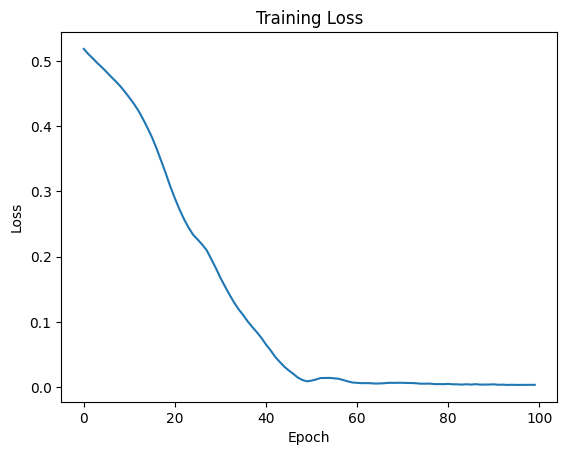

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

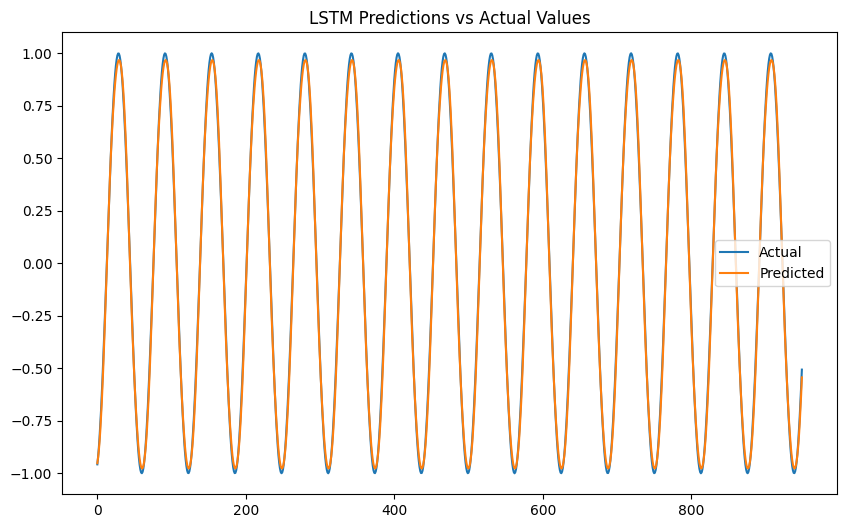

In [7]:
model.eval()
with torch.no_grad():
    test_predictions = model(X)

plt.figure(figsize=(10, 6))
plt.plot(y.numpy(), label='Actual')
plt.plot(test_predictions.numpy(), label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual Values')
plt.show()